# Sprint 13 Project: Time Series

## Project Description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project Instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data Description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Initialization

In [1]:
# Import libraries required for analysis
import pandas as pd
import numpy as np

# For timing code execution/training/prediction
import time

# For sqrt
import math

# For plotting timeseries data
import matplotlib.pyplot as plt

# For viewing seasonality and trends
from statsmodels.tsa.seasonal import seasonal_decompose

# Dickey-Fuller 
from statsmodels.tsa.stattools import adfuller

# Create training and test sets
from sklearn.model_selection import train_test_split

# For scaling
from sklearn.preprocessing import StandardScaler

# LinearRegression Model 
from sklearn.linear_model import LinearRegression

# For RMSE
from sklearn.metrics import mean_squared_error

# For AutoRegressive model and selecting lag 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# For Moving Average model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

# For Auto-ARIMA modeling
import pmdarima as pm
from pmdarima import auto_arima

# Regression models
from sklearn.ensemble import RandomForestRegressor

# Grid search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# https://lightgbm.readthedocs.io/en/stable/Python-Intro.html
from lightgbm import LGBMRegressor

# https://catboost.ai/en/docs/concepts/python-usages-examples
from catboost import CatBoostRegressor

#https://xgboost.readthedocs.io/en/stable/python/python_api.html
from xgboost import XGBRegressor

### Read in Data

In [2]:
# Read in data csv and convert to dataframe
# The dates are in the first column (0) which will be used as the index and also so the dataframe parses dates
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Sort index ascending
data.sort_index(inplace=True)

# Resample data by daily intervals
# This will be used to view trends
data_daily = data.resample('1D').sum()

# Resample data by hourly intervals
# This will be used for modeling since we want to predict the amount of taxi orders for the next hour
data_hourly = data.resample('1H').sum()

### View Sample of Data

In [26]:
data_hourly.head(10)
data_daily.head(10)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441
2018-03-08,1659
2018-03-09,1076


## Data Analysis

### Explore Data

In [4]:
# Use print so I don't lose outputs
# Check for missing values
print('Check for Missing Values (Hourly)')
print(data_hourly.isna().sum())
print()

print('Check for Missing Values (Daily)')
print(data_daily.isna().sum())
print()

# Check that the data (index) is in chronological order
print('Data is in chronological order -', data.index.is_monotonic)
print()

# Check values for each column
print('Describe Dataframe (Hourly)')
print(data_hourly.describe())
print()

print('Describe Dataframe (Daily)')
print(data_daily.describe())
print()

# Check data types
print('Check Data Types (Hourly)')
print(data_hourly.info())
print()
print('Check Data Types (Daily)')
print(data_daily.info())
print()

# Check data types
print('Check Timeframe of Dataset')
print('The time range of the data set is', data_hourly.index.min(), 'to',data_hourly.index.max())
print()

Check for Missing Values (Hourly)
num_orders    0
dtype: int64

Check for Missing Values (Daily)
num_orders    0
dtype: int64

Data is in chronological order - True

Describe Dataframe (Hourly)
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Describe Dataframe (Daily)
        num_orders
count   184.000000
mean   2026.146739
std     635.874120
min    1076.000000
25%    1547.500000
50%    1911.500000
75%    2349.750000
max    4090.000000

Check Data Types (Hourly)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

Check Data Types (Daily)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-0

### Check for Outliers

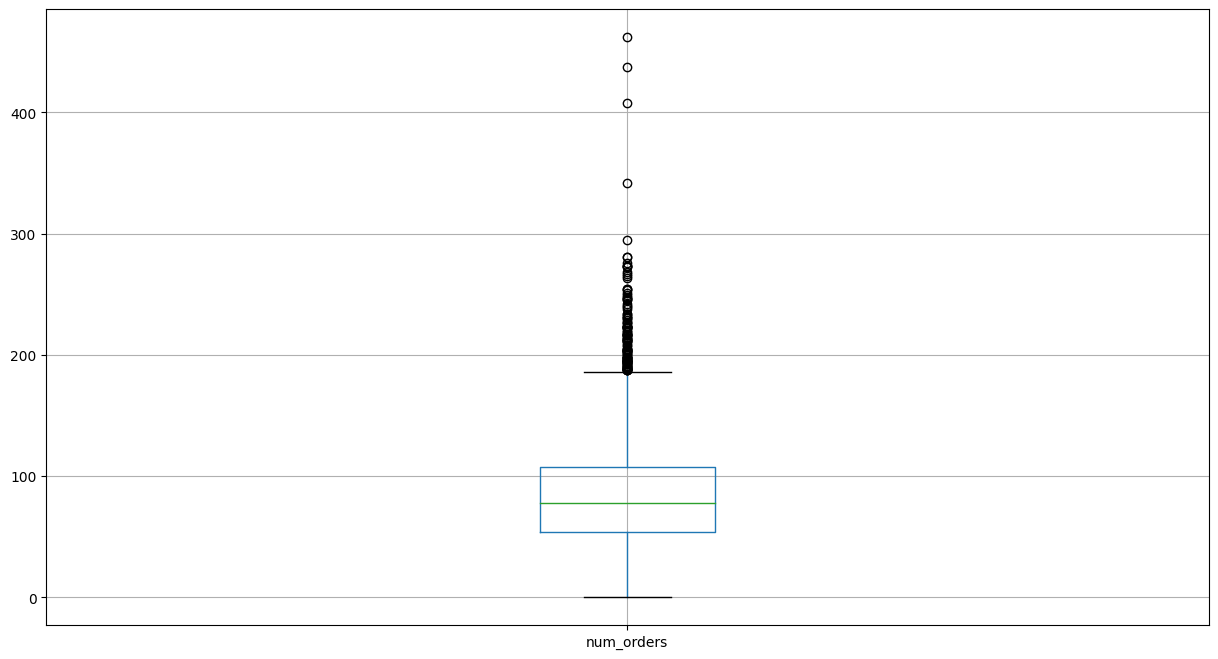

,num_orders
datetime,
2018-04-24 00:00:00,253.0
2018-05-03 00:00:00,201.0
2018-05-18 22:00:00,193.0
2018-05-18 23:00:00,197.0
2018-05-19 00:00:00,234.0



There are 121 outliers


In [5]:
# Create boxplot to view if there are any outliers (using hourly data to be more thorough)
plt.figure(figsize = (15, 8))
data_hourly.boxplot()
plt.show()
     
# Create function for finding outliers
def find_outliers_IQR(df):

    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Determine interquartile range (IQR)
    IQR = q3 - q1
    # Outliers are values that fall outside 1.5 x IQR above and below
    outliers = df[(df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))]

    # Return outliers and count of outliers
    return outliers.dropna(), outliers.dropna().shape
    
       
# Run function using hourly data
outlier_df, outlier_shape = find_outliers_IQR(data_hourly)

# Display sample of outliers
display(outlier_df.head())
print()

# Print count of outliers
print('There are', outlier_shape[0],'outliers')

#### Drop Outliers

In [6]:
# Check how many rows there should be after dropping outliers
new_row_size = data_hourly.shape[0] - outlier_df.shape[0]
print('After removing outliers there should be', new_row_size, 'rows')
print()

# Remove outliers and print new row count
print('Removing outliers for dataset')
data_hourly = data_hourly[~data_hourly.index.isin(outlier_df.index)]
print('There are now', data_hourly.shape[0], 'rows')

data_hourly.info()
data_hourly.head(10)

After removing outliers there should be 4295 rows

Removing outliers for dataset
There are now 4295 rows
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4295 entries, 2018-03-01 00:00:00 to 2018-08-31 21:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4295 non-null   int64
dtypes: int64(1)
memory usage: 67.1 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


### Explore Trends and Seasonality with Plots

I plotted both hourly and daily data in different ways to determine patterns based on visibility in plots. It's important to check all of these timescales with different granularities in order to check for all patterns in the data:
- Hourly
    - Trend for first week of data (3/1/2018 - 3/7/2018)
    - Trend for all data (3/1/2018 - 8/31/2018)
    - Seasonality for first three days of data, separately (3/1/2018, 3/2/2018, 3/3/2018)
    - Residuals for first week of data (3/1/2018 - 3/7/2018)
- Daily (week period)
    - Trend for all data (3/1/2018 - 8/31/2018)
    - Seasonality for first and second weeks of data, separately (3/1/2018 - 3/7/2018, 3/8/2018 - 3/14/2018)
    - Residuals for all data (3/1/2018 - 8/31/2018)
- Daily (month period)
    - Trend for all data (3/1/2018 - 8/31/2018)
    - Seasonality for first and second months of data, separately (March 2018, April 2018)
    - Residuals for all data (3/1/2018 - 8/31/2018)    

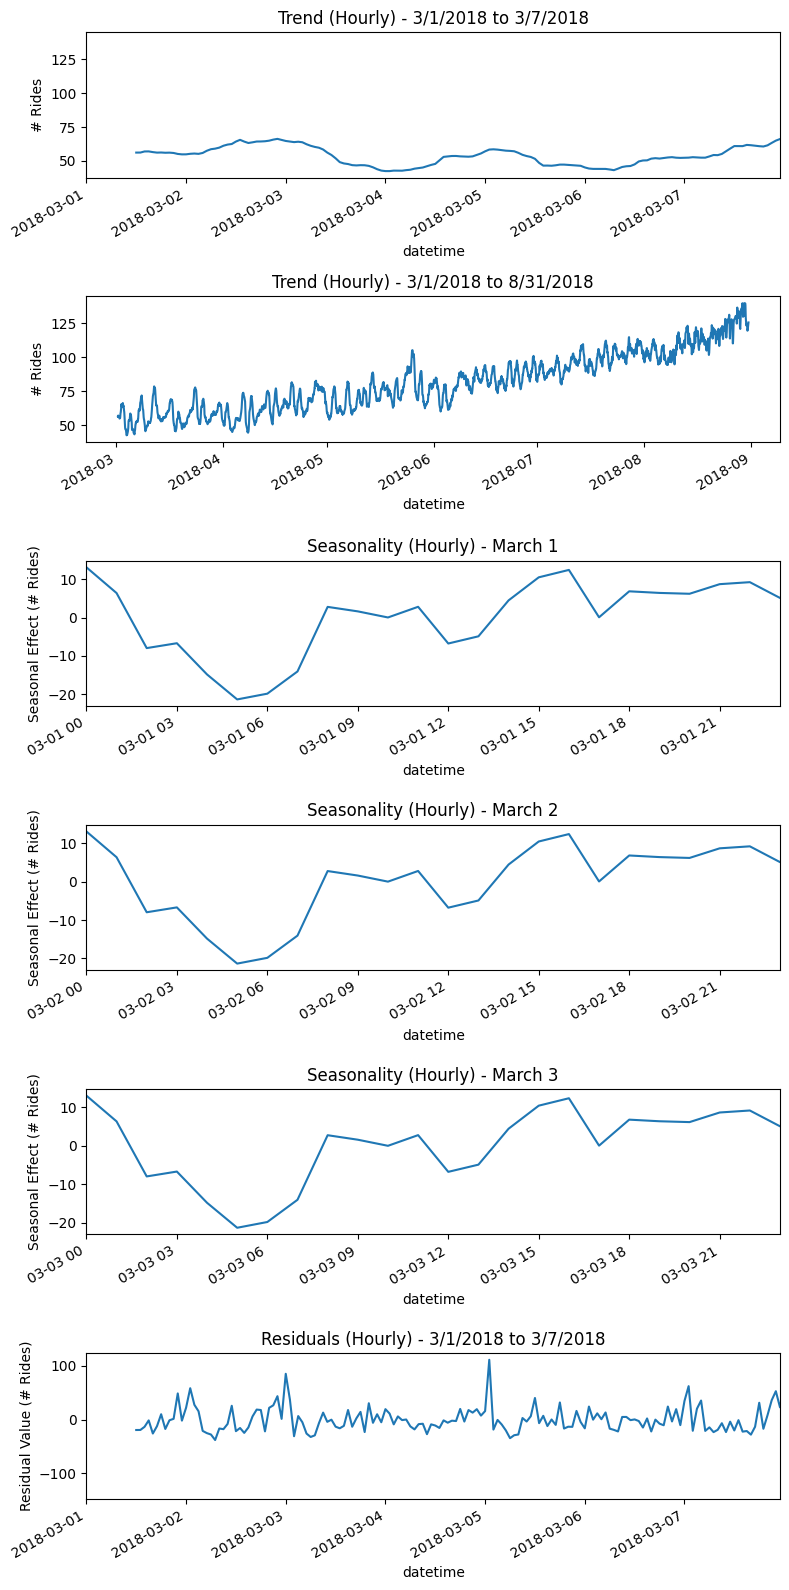

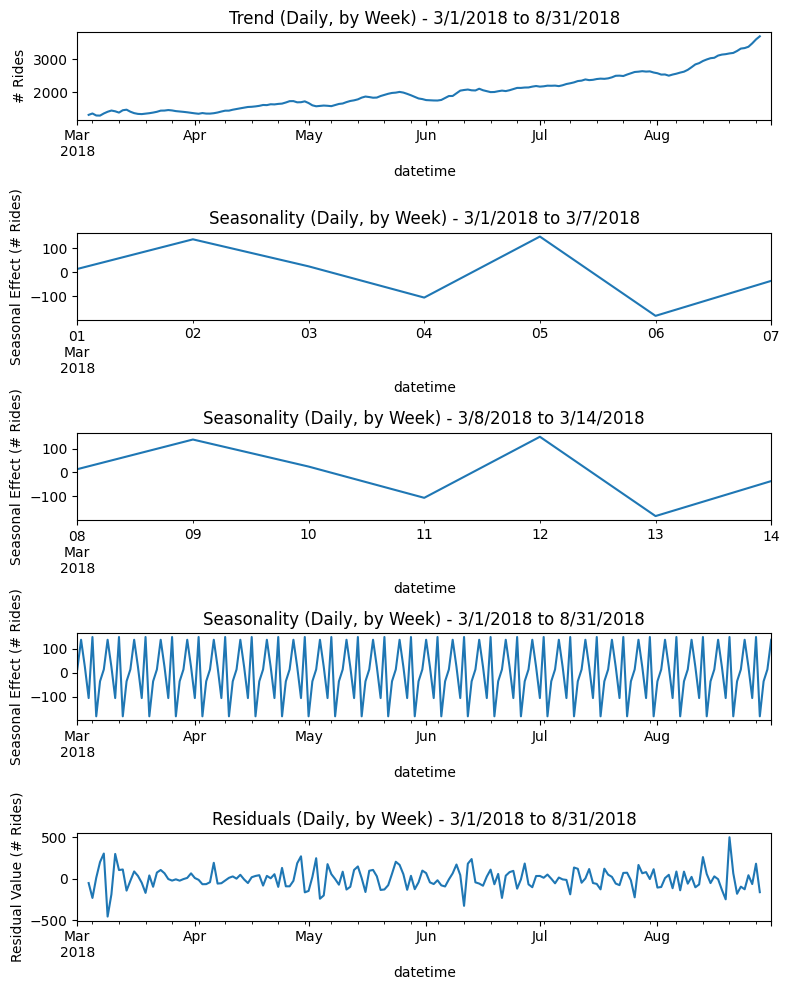

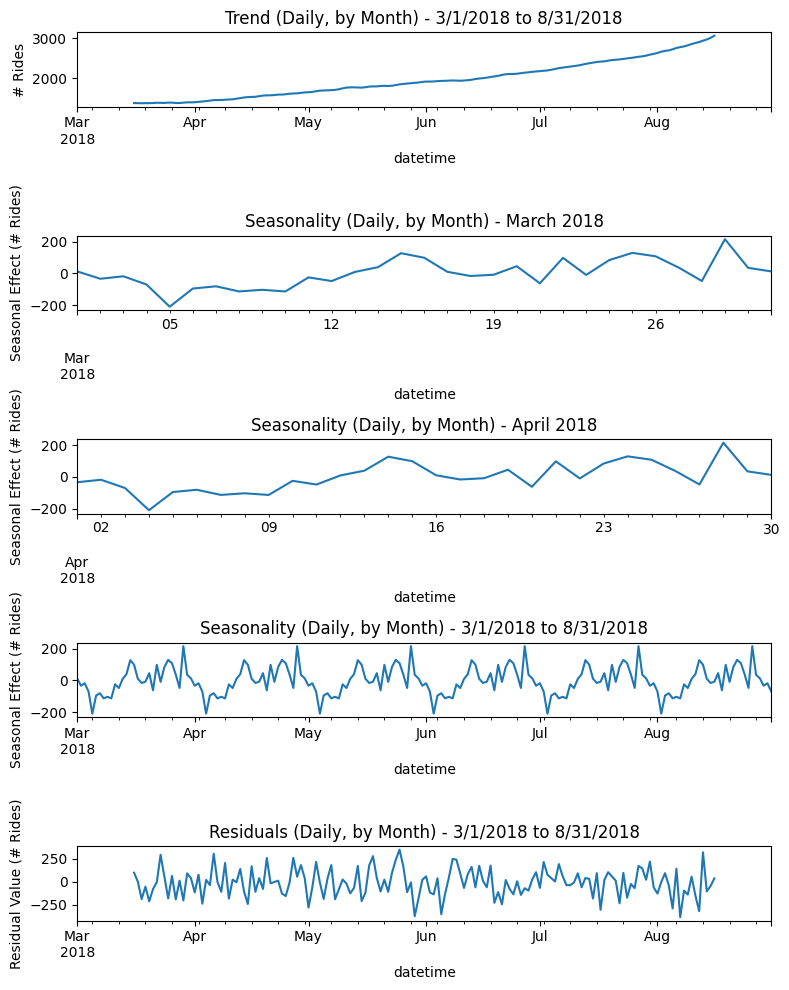

In [7]:
# Hourly data
# Create seasonal_decompose object with a period of 24 (representing 24 unique hours per day)
decomposed = seasonal_decompose(data_hourly, period=24)

# Create figure
plt.figure(figsize=(8, 16))

# Plot Trend, Seasonality, and Residuals
plt.subplot(611)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend (Hourly) - 3/1/2018 to 3/7/2018')
plt.xlim('2018-03-01 00:00:00', '2018-03-07 23:00:00')
plt.ylabel('# Rides')

plt.subplot(612)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend (Hourly) - 3/1/2018 to 8/31/2018')
plt.ylabel('# Rides')

plt.subplot(613)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Hourly) - March 1')
plt.xlim('2018-03-01 00:00:00', '2018-03-01 23:00:00')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(614)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Hourly) - March 2')
plt.xlim('2018-03-02 00:00:00', '2018-03-02 23:00:00')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(615)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Hourly) - March 3')
plt.xlim('2018-03-03 00:00:00', '2018-03-03 23:00:00')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(616)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals (Hourly) - 3/1/2018 to 3/7/2018')
plt.xlim('2018-03-01 00:00:00', '2018-03-07 23:00:00')
plt.ylabel('Residual Value (# Rides)')

# Plot data
plt.tight_layout()


# Daily data (weekly periodicity)
# Create seasonal_decompose object with a period of 7 (representing 7 unique days per week)
decomposed = seasonal_decompose(data_daily, period=7)

# Create figure
plt.figure(figsize=(8, 10))

# Plot Trend, Seasonality, and Residuals
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend (Daily, by Week) - 3/1/2018 to 8/31/2018')
plt.ylabel('# Rides')

plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Week) - 3/1/2018 to 3/7/2018')
plt.xlim('2018-03-01', '2018-03-07')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(513)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Week) - 3/8/2018 to 3/14/2018')
plt.xlim('2018-03-08', '2018-03-14')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(514)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Week) - 3/1/2018 to 8/31/2018')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals (Daily, by Week) - 3/1/2018 to 8/31/2018')
plt.ylabel('Residual Value (# Rides)')

# Plot data
plt.tight_layout()


# Daily data (monthly periodicity)
# Create seasonal_decompose object with a period of 30 (the true period is closer to 30.5 unique days
# per month from March to August but decimals are not allowed in the period parameter - I will make manual adjustments)
decomposed = seasonal_decompose(data_daily, period=30)

# Create figure
plt.figure(figsize=(8, 10))

# Plot Trend, Seasonality, and Residuals
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend (Daily, by Month) - 3/1/2018 to 8/31/2018')
plt.ylabel('# Rides')

plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Month) - March 2018')
plt.xlim('2018-03-01', '2018-03-31')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(513)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Month) - April 2018')
plt.xlim('2018-04-01', '2018-04-30')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(514)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (Daily, by Month) - 3/1/2018 to 8/31/2018')
plt.ylabel('Seasonal Effect (# Rides)')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals (Daily, by Month) - 3/1/2018 to 8/31/2018')
plt.ylabel('Residual Value (# Rides)')

# Plot data
plt.tight_layout()

### Data Exploration Summary

#### Overall Summary of Data
- The timeframe of the data is 3/1/2018 to 8/31/2018. Therefore we have 6 full months of data to use for modeling and predictions.
- Using hourly resampling, there are no missing values in the data.
- Before dropping outliers, the mean number of hourly rides was 84 with a variance of 45. The maximum was 462, which likely occurred on a holiday or other event. This is why dropping outliers in this case was important.
    - Outliers accounted for 2.7% of the data (121 out of 4416). Because this is a small percentage, they have been removed from the data.
    
#### Observations and Analysis of Time Series
- Observations from hourly data plots:
    - Taxi rides have hourly seasonality when viewing a one day period
        - Between 2 and 8 AM, rides are below average. 
        - They are higher during the other hours, peaking at midnight and 4 PM.
    - Hourly taxi ride data is nonstationary
        - The mean number of rides appears to increase over the 6 month period for which we have data. 
        - To be able to make predictions, we may have to make the series stationary by calculating differences in values (lag).
- Observations from daily (week period) plots:
    - Taxi rides have daily seasonality when looking at weekly periods
        - March 1, 2018, is a Thursday, therefore, from the plot, rides are highest on weekdays with the exception of Tuesday during the weeks of March 1 to 7 and March 8 to 14.
            - Rides on Saturday, Sunday, and Tuesday are at or below average.
        - As seen on the plot of the entire 6 month time period, there is a distinct weekly recurring pattern in the data, likely following the above pattern.
    - Daily taxi ride data is nonstationary
        - This is expected, since this data is just a more granular view of the daily data, which is also nonstationary.
            - This will be addressed in the next section.        
- Observations from daily (month period) data plots:
    - Taxi rides have daily seasonality when looking at monthly periods
        - There appears to be a drop in taxi rides near the beginning of each month.
        - Specifically, ridership is at its lowest on Monday, March 5, and Tuesday, April 3 (adjusting for `period=30` parameter).
        
#### Next Steps
- Going forward, we will only use hourly data for model training and prediction.

## Training

### Feature Development

To help train models, we must create and add several features to the hourly data:
- Additional datetime components
    - Month
    - Day
    - Day of Week
    - Hour
- Lag features
    - Previous data helps predict the following data, so having a difference between chronologically adjacent values is important
- Rolling mean
    - Helps understand trend as time progresses through the daily period of hourly observations (24 hours)

It is also important for time series modeling to have a stationary dataset, either by converting a nonstationary dataset, or accounting for it in the modeling process. Since the hourly data is nonstationary and there is daily seasonality, I am selecting the following in order to create a stationary dataset:
- Lag period: 4 hours
- Rolling mean period: 24 hours

In [8]:
# Create a function that adds features to the training data. Taken from Sprint 13, Section 3 - Creating Features
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Lag
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Rolling mean
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    # Return dataframe
    return data

# Run function using 4 hour lag and a 24 hour rolling mean
make_features(data_hourly, 4, 24)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 14:00:00,133,8,31,4,14,166.0,136.0,167.0,182.0,124.791667
2018-08-31 15:00:00,116,8,31,4,15,133.0,166.0,136.0,167.0,123.250000
2018-08-31 19:00:00,136,8,31,4,19,116.0,133.0,166.0,136.0,120.708333


### Split Data into Training and Test Sets

We will split the data into Training, Test, and Validation sets. The Test and Validation sets will each be 10% of the total.

In [9]:
# Set random state to 12345 to replicate training set in future

# Ensure missing values are dropped before splitting
data_hourly = data_hourly.dropna()

# Set test size to be 10% of original dataset
training_set, test_set_to_split = train_test_split(data_hourly, shuffle=False, test_size=0.2, random_state=12345)

# Split training_set_to_split create a validation and training set - validation is listed first here so it is
# chronologically after the training set, and the test set is chronologically last
validation_set, test_set = train_test_split(test_set_to_split, shuffle=False, test_size=0.5, random_state=12345)

# Create the features and target training datasets
features_train = training_set.drop(['num_orders'], axis=1)
target_train = training_set['num_orders']

# Create the features and target validation datasets
features_valid = validation_set.drop(['num_orders'], axis=1)
target_valid = validation_set['num_orders']

# Create the features and target test datasets
features_test = test_set.drop(['num_orders'], axis=1)
target_test = test_set['num_orders']

# Check Training (80%)
print('Training')
print(features_train.shape) 
print(target_train.shape) 
print('Start:', features_train.index.min(), '-', 'End:', features_train.index.max())
print()

# Check Validation (10%)
print('Validation')
print(features_valid.shape) 
print(target_valid.shape)   
print('Start:', features_valid.index.min(), '-', 'End:', features_valid.index.max())
print()

# Check Test (10%)
print('Test')
print(features_test.shape)  
print(target_test.shape)    
print('Start:', features_test.index.min(), '-', 'End:', features_test.index.max())
print()

# The Test set has one additional row than the Test set - because the data is chronological, I will drop the final value
features_test = features_test.drop(features_test.index[-1])
target_test = target_test.drop(target_test.index[-1])

Training
(3416, 9)
(3416,)
Start: 2018-03-02 00:00:00 - End: 2018-07-22 23:00:00

Validation
(427, 9)
(427,)
Start: 2018-07-23 01:00:00 - End: 2018-08-10 11:00:00

Test
(428, 9)
(428,)
Start: 2018-08-10 12:00:00 - End: 2018-08-31 21:00:00



### Feature Scaling

The data must be standardized to prevent larger values from having higher weight in the modeling process. This process is crucial for machine learning algorithms, especially models more sensitive to feature scaling. 

Because we introduced several new features, most of which are around 0 or 1, the number of rides would end up with too high of a weight attached to it compared to the new features.

To accomplish feature scaling, I will use the following:
- For the `hour` variable, I plan to use `sin` and `cos` transformations in order to better preserve the cyclical nature of a 24 hour cycle.
- StandardScaler will be used to create a balanced scale of the number of rides over the time series.

In [10]:
# Create a list of features that need to be scaled
# Scaling is needed because these values are much larger than 0/1 and we don't want the model to overfit for these features
# Hour is being excluded from this section (see next cell)
features_to_scale = ['lag_1','lag_2','lag_3','lag_4','rolling_mean']

# Fit StandardScaler to scale features for training set only
# Then apply the same scaler to transform all three sets (train, validation and test)
# The scaler is never fit using validation/test data
transformer = StandardScaler().fit(features_train[features_to_scale].to_numpy())

# Create a copy of df with scaled/transformed features 
# Apply the same scaler to transform all three sets (train, validation and test) using transformer
# Train
features_train_scaled = features_train.copy()
features_train_scaled.loc[:, features_to_scale] = transformer.transform(features_train[features_to_scale].to_numpy())

# Validation
features_valid_scaled = features_valid.copy()
features_valid_scaled.loc[:, features_to_scale] = transformer.transform(features_valid[features_to_scale].to_numpy())

# Test
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, features_to_scale] = transformer.transform(features_test[features_to_scale].to_numpy())

# Print sample of scaled trained dataset after StandardScaler
print('Train')
display(features_train_scaled.head())

print('Validation')
display(features_valid_scaled.head())

print('Test')
display(features_test_scaled.head())

Train


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-02 00:00:00,3,2,4,0,-0.439681,1.169190,-0.205393,-0.351372,-1.049222
2018-03-02 01:00:00,3,2,4,1,0.496478,-0.439718,1.169649,-0.205081,-1.141685
2018-03-02 02:00:00,3,2,4,2,1.374128,0.496374,-0.439443,1.170052,-1.046503
2018-03-02 03:00:00,3,2,4,3,0.057654,1.373961,0.496756,-0.439147,-1.035625
2018-03-02 04:00:00,3,2,4,4,-0.264151,0.057581,1.374443,0.497115,-1.041064


Validation


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-07-23 01:00:00,7,23,0,1,2.398053,0.935167,0.906343,0.760438,1.537026
2018-07-23 02:00:00,7,23,0,2,1.812953,2.397811,0.935599,0.906729,1.479916
2018-07-23 03:00:00,7,23,0,3,3.187937,1.812754,2.398410,0.935987,1.727391
2018-07-23 04:00:00,7,23,0,4,1.461893,3.187639,1.813286,2.398895,1.798098
2018-07-23 05:00:00,7,23,0,5,1.491148,1.461719,3.188328,1.813732,1.787220


Test


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-08-10 12:00:00,8,10,4,12,2.749113,2.339306,0.233450,-0.175823,1.942232
2018-08-10 13:00:00,8,10,4,13,1.140088,2.748846,2.339898,0.233791,1.841611
2018-08-10 14:00:00,8,10,4,14,1.286363,1.139937,2.749485,2.340379,1.928635
2018-08-10 15:00:00,8,10,4,15,0.554988,1.286202,1.140393,2.749993,1.844330
2018-08-10 16:00:00,8,10,4,16,0.964558,0.554880,1.286674,1.140794,1.917757


In [11]:
# Perform cyclical encoding on categorical time-based variables (month,day, dayofweek, and hour) using sin and cos on previously scaled dataframes
features_train_scaled['hour_sin'] = np.sin(2 * np.pi * features_train_scaled['hour'] / 24)
features_train_scaled['hour_cos'] = np.cos(2 * np.pi * features_train_scaled['hour'] / 24)
features_valid_scaled['hour_sin'] = np.sin(2 * np.pi * features_valid_scaled['hour'] / 24)
features_valid_scaled['hour_cos'] = np.cos(2 * np.pi * features_valid_scaled['hour'] / 24)
features_test_scaled['hour_sin'] = np.sin(2 * np.pi * features_test_scaled['hour'] / 24)
features_test_scaled['hour_cos'] = np.cos(2 * np.pi * features_test_scaled['hour'] / 24)

features_train_scaled['month_sin'] = np.sin(2 * np.pi * features_train_scaled['month'] / 6)  # 6 months in dataset
features_train_scaled['month_cos'] = np.cos(2 * np.pi * features_train_scaled['month'] / 6)
features_valid_scaled['month_sin'] = np.sin(2 * np.pi * features_valid_scaled['month'] / 6)
features_valid_scaled['month_cos'] = np.cos(2 * np.pi * features_valid_scaled['month'] / 6)
features_test_scaled['month_sin'] = np.sin(2 * np.pi * features_test_scaled['month'] / 6)
features_test_scaled['month_cos'] = np.cos(2 * np.pi * features_test_scaled['month'] / 6)

features_train_scaled['day_sin'] = np.sin(2 * np.pi * features_train_scaled['day'] / 31)
features_train_scaled['day_cos'] = np.cos(2 * np.pi * features_train_scaled['day'] / 31)
features_valid_scaled['day_sin'] = np.sin(2 * np.pi * features_valid_scaled['day'] / 31)
features_valid_scaled['day_cos'] = np.cos(2 * np.pi * features_valid_scaled['day'] / 31)
features_test_scaled['day_sin'] = np.sin(2 * np.pi * features_test_scaled['day'] / 31)
features_test_scaled['day_cos'] = np.cos(2 * np.pi * features_test_scaled['day'] / 31)

features_train_scaled['dayofweek_sin'] = np.sin(2 * np.pi * features_train_scaled['dayofweek'] / 7)
features_train_scaled['dayofweek_cos'] = np.cos(2 * np.pi * features_train_scaled['dayofweek'] / 7)
features_valid_scaled['dayofweek_sin'] = np.sin(2 * np.pi * features_valid_scaled['dayofweek'] / 7)
features_valid_scaled['dayofweek_cos'] = np.cos(2 * np.pi * features_valid_scaled['dayofweek'] / 7)
features_test_scaled['dayofweek_sin'] = np.sin(2 * np.pi * features_test_scaled['dayofweek'] / 7)
features_test_scaled['dayofweek_cos'] = np.cos(2 * np.pi * features_test_scaled['dayofweek'] / 7)

# Drop original features that were just encoded from data to avoid redundancy
features_train_scaled = features_train_scaled.drop(columns=['hour'])
features_valid_scaled = features_valid_scaled.drop(columns=['hour'])
features_test_scaled = features_test_scaled.drop(columns=['hour'])
                                            
features_train_scaled = features_train_scaled.drop(columns=['month'])
features_valid_scaled = features_valid_scaled.drop(columns=['month'])
features_test_scaled = features_test_scaled.drop(columns=['month'])                                            

features_train_scaled = features_train_scaled.drop(columns=['day'])
features_valid_scaled = features_valid_scaled.drop(columns=['day'])
features_test_scaled = features_test_scaled.drop(columns=['day'])

features_train_scaled = features_train_scaled.drop(columns=['dayofweek'])
features_valid_scaled = features_valid_scaled.drop(columns=['dayofweek'])
features_test_scaled = features_test_scaled.drop(columns=['dayofweek'])                                           
                                            
# Print sample of scaled trained dataset after StandardScaler and hour sin/cos transformations
print('Train')
display(features_train_scaled.head())

print('Validation')
display(features_valid_scaled.head())

print('Test')
display(features_test_scaled.head())

Train


,lag_1,lag_2,lag_3,lag_4,rolling_mean,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,-0.439681,1.169190,-0.205393,-0.351372,-1.049222,0.000000,1.000000,1.224647e-16,-1.0,0.394356,0.918958,-0.433884,-0.900969
2018-03-02 01:00:00,0.496478,-0.439718,1.169649,-0.205081,-1.141685,0.258819,0.965926,1.224647e-16,-1.0,0.394356,0.918958,-0.433884,-0.900969
2018-03-02 02:00:00,1.374128,0.496374,-0.439443,1.170052,-1.046503,0.500000,0.866025,1.224647e-16,-1.0,0.394356,0.918958,-0.433884,-0.900969
2018-03-02 03:00:00,0.057654,1.373961,0.496756,-0.439147,-1.035625,0.707107,0.707107,1.224647e-16,-1.0,0.394356,0.918958,-0.433884,-0.900969
2018-03-02 04:00:00,-0.264151,0.057581,1.374443,0.497115,-1.041064,0.866025,0.500000,1.224647e-16,-1.0,0.394356,0.918958,-0.433884,-0.900969


Validation


,lag_1,lag_2,lag_3,lag_4,rolling_mean,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,,,,,,,
2018-07-23 01:00:00,2.398053,0.935167,0.906343,0.760438,1.537026,0.258819,0.965926,0.866025,0.5,-0.998717,-0.050649,0.0,1.0
2018-07-23 02:00:00,1.812953,2.397811,0.935599,0.906729,1.479916,0.500000,0.866025,0.866025,0.5,-0.998717,-0.050649,0.0,1.0
2018-07-23 03:00:00,3.187937,1.812754,2.398410,0.935987,1.727391,0.707107,0.707107,0.866025,0.5,-0.998717,-0.050649,0.0,1.0
2018-07-23 04:00:00,1.461893,3.187639,1.813286,2.398895,1.798098,0.866025,0.500000,0.866025,0.5,-0.998717,-0.050649,0.0,1.0
2018-07-23 05:00:00,1.491148,1.461719,3.188328,1.813732,1.787220,0.965926,0.258819,0.866025,0.5,-0.998717,-0.050649,0.0,1.0


Test


,lag_1,lag_2,lag_3,lag_4,rolling_mean,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,,,,,,,
2018-08-10 12:00:00,2.749113,2.339306,0.233450,-0.175823,1.942232,1.224647e-16,-1.000000,0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969
2018-08-10 13:00:00,1.140088,2.748846,2.339898,0.233791,1.841611,-2.588190e-01,-0.965926,0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969
2018-08-10 14:00:00,1.286363,1.139937,2.749485,2.340379,1.928635,-5.000000e-01,-0.866025,0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969
2018-08-10 15:00:00,0.554988,1.286202,1.140393,2.749993,1.844330,-7.071068e-01,-0.707107,0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969
2018-08-10 16:00:00,0.964558,0.554880,1.286674,1.140794,1.917757,-8.660254e-01,-0.500000,0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969


### Modeling and Evalulation

In this section, a function will be used to take a model by name and return:

- Best hyperparameters (by RMSE)
- RMSE
    - With training data
    - With validation data
- Time elapsed
    - Training
    - Prediction

In [12]:
# Create model evaluation function 
# For model tuning, we will use GridSearchCV and keep the search space constant across models
def model_evaluation(model,model_name):
    
    # Create a search space to optimize for best combination of n_estimators and max_depth
    search_space = {'n_estimators': [5,10,20]
                    , 'max_depth': [5,10,20]}
       
    # Initialize Model
    model = model
    
    # Time Series cross-validator
    # Provides train/test indices to split time series data samples that are observed at fixed time intervals
    tscv = TimeSeriesSplit(n_splits=5)

    # Create a GridSearchCV Object
    # Use n-splits for cross-validation - using n_splits = 5
    # Select Best Model Using neg_root_mean_squared_error as Scorer function 
    model_grid = GridSearchCV(model, param_grid = search_space, cv = tscv, scoring = 'neg_root_mean_squared_error', verbose = 0)

    # Start training timer
    start_train = time.time()

    # Fit model to training data
    model_grid.fit(features_train, target_train)
    
    # End training timer and calculate training time elapsed
    end_train = time.time()
    elapsed_train = end_train - start_train

    # Save best parameters to variable that produce the smallest RMSE
    # best_parameters will contain a dictionary of the best parameters that produced the lowest RMSE
    best_parameters = model_grid.best_params_

    # Best score is the RMSE value on the training data
    best_score = model_grid.best_score_

    # Best grid will contain the parameters that can be used to predict values on the validation set
    # The refitted estimator is made available at the best_estimator_ attribute and permits using predict directly on this GridSearchCV instance
    best_grid = model_grid.best_estimator_

    # Start prediction timer
    start_pred = time.time()
    
    # Predict target values on the validation set
    predicted_values = best_grid.predict(features_valid)

    # End prediction timer and calculate prediction time elapsed in ms
    end_pred = time.time()
    elapsed_pred = (end_pred - start_pred) * 1000
    
    # Calculate RMSE between predicted target and actual target for validation set
    RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

    # Print results of tuning and RMSE on validation set 
    # Negating RMSE result from GridSearchCV to make it positive and match other values
    print("Best hyperparameters For", model_name,":", best_parameters )
    print("These hyperparameters produced a best RMSE score of", round(-best_score,2), "on the training data")
    print()
    print("The RMSE using the tuned", model_name, "on the validation set:", round(RMSE,2))
    print()
    
    # Create plot that shows predicted vs actuals for validation set
    
    # Convert predictions and actuals to list
    actual = target_valid.tolist() #y-axis
    predicted = predicted_values.tolist() #y-axis
    x_axis = target_valid.index.tolist() #x-axis
    
    # Configurations for plotting
    plt.figure(figsize=(15, 5))
    plt.plot(x_axis, actual, label = "Target Values") 
    plt.plot(x_axis, predicted, label = "Predicted Values")
    
    # Add titles
    plt.xlabel("Date")
    plt.ylabel("Number of Taxi Orders Per Hour")
    plt.title(model_name)
    
    # Plot
    plt.legend()
    plt.show()
    
    # Print prediction time for model
    print()
    print('Training time for', model_name,':', round(elapsed_train,2))
    print('Prediction time for', model_name,':', round(elapsed_pred,2))

#### Linear Regression

No hyperparameter tuning will be performed on this model.

The RMSE for the LinearRegression Model (validation set) is: 32.83


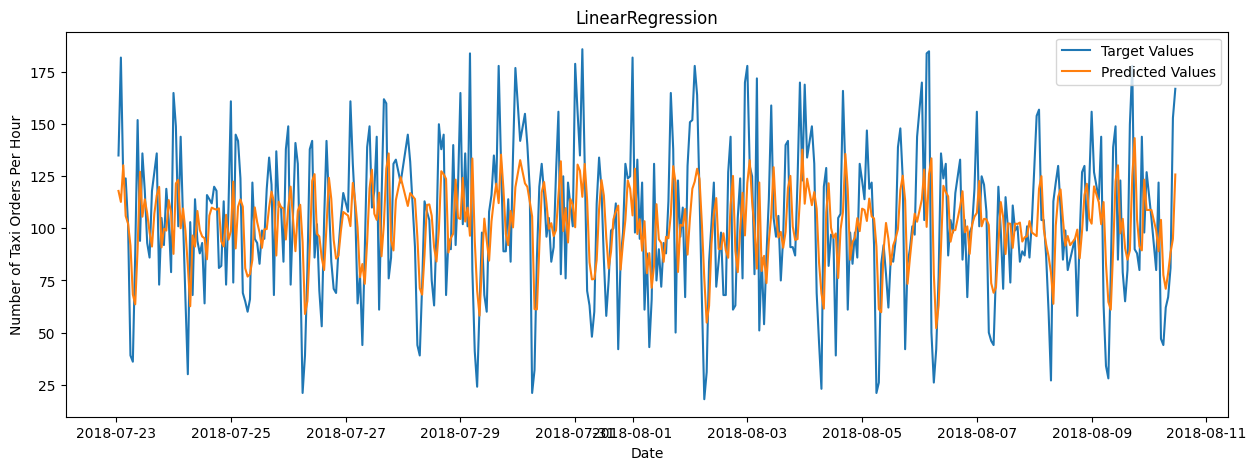


Training time for Linear Regression : 0.0 s.
Prediction time for Linear Regression : 1.07 ms.
Code cell run time for LinearRegression:
CPU times: user 213 ms, sys: 69.3 ms, total: 282 ms
Wall time: 283 ms


In [13]:
%%time 

# Add model name manually since not using function
model_name = 'Linear Regression'

# Initialize model
model = LinearRegression()

# Start training timer
start_train = time.time()

# Fit model to training data
model.fit(features_train, target_train)

# End training timer and calculate trainingtime elapsed
end_train = time.time()
elapsed_train = end_train - start_train

# Start prediction timer
start_pred = time.time()

# Predict test target
predicted_values = model.predict(features_valid)

# End prediction timer and calculate prediction time elapsed in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

# Print RMSE
print('The RMSE for the LinearRegression Model (validation set) is:', round(RMSE,2))

# Create plot that shows predicted vs actuals for validation set
# Convert predictions and acutals to list
actual = target_valid.tolist() #y-axis
predicted = predicted_values.tolist() #y-axis
x_axis = target_valid.index.tolist() #x-axis

# Configurations for plotting
plt.figure(figsize=(15, 5))
plt.plot(x_axis, actual, label = "Target Values") 
plt.plot(x_axis, predicted, label = "Predicted Values")

# Add titles
plt.xlabel("Date")
plt.ylabel("Number of Taxi Orders Per Hour")
plt.title('LinearRegression')

# Plot
plt.legend()
plt.show()

# Print time elapsed for training, prediction, and code cell
print()
print('Training time for', model_name,':', round(elapsed_train,2), 's.')
print('Prediction time for', model_name,':', round(elapsed_pred,2), 'ms.')
print('Code cell run time for LinearRegression:')

#### RandomForest

Random Forest Regression is a versatile machine-learning technique for predicting numerical values. It combines the predictions of multiple decision trees to reduce overfitting and improve accuracy.

Best hyperparameters For RandomForest : {'max_depth': 20, 'n_estimators': 20}
These hyperparameters produced a best RMSE score of 23.15 on the training data

The RMSE using the tuned RandomForest on the validation set: 24.84



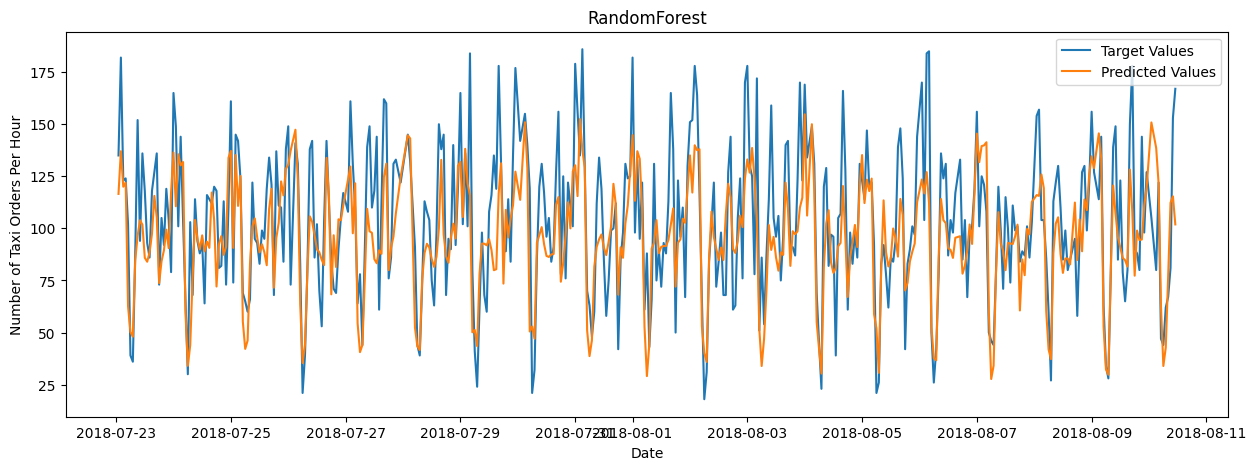


Training time for RandomForest : 2.81
Prediction time for RandomForest : 4.1
CPU times: user 2.98 s, sys: 8.71 ms, total: 2.99 s
Wall time: 3.05 s


In [14]:
%%time

# Set variables to RandomForestRegressor
model = RandomForestRegressor()
model_name = 'RandomForest'

# Configure model_evaluation to use RandomForestRegressor
model_evaluation(model, model_name)

#### LightGBM

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.

Best hyperparameters For LightGBM : {'max_depth': 20, 'n_estimators': 20}
These hyperparameters produced a best RMSE score of 23.8 on the training data

The RMSE using the tuned LightGBM on the validation set: 27.09



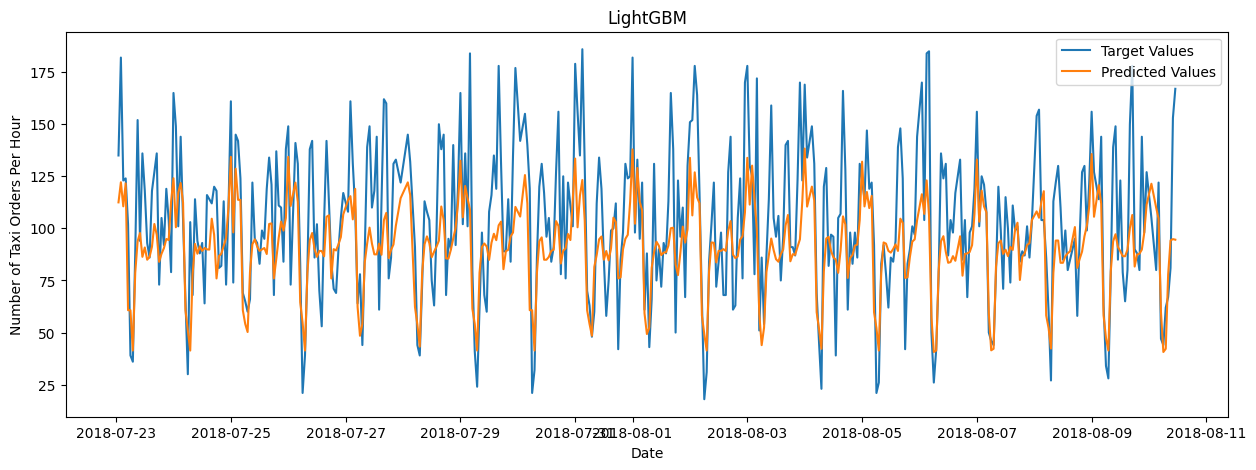


Training time for LightGBM : 234.44
Prediction time for LightGBM : 7.14
CPU times: user 3min 53s, sys: 327 ms, total: 3min 54s
Wall time: 3min 54s


In [15]:
%%time

# Set variables to LGBMRegressor
model = LGBMRegressor(random_state=12345)
model_name = 'LightGBM'

# Configure model_evaluation to use LGBMRegressor
model_evaluation(model, model_name)

#### CatBoost

**CatBoost** is a popular and high-performance open-source implementation of the Gradient Boosting Decision Tree (GBDT) algorithm. GBDT is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. CatBoost introduces two critical algorithmic advances to GBDT:

- The implementation of ordered boosting, a permutation-driven alternative to the classic algorithm
- An innovative algorithm for processing categorical features

Both techniques were created to fight a prediction shift caused by a special kind of target leakage present in all currently existing implementations of gradient boosting algorithms.

Learning rate set to 0.5
0:	learn: 22.9918100	total: 46.6ms	remaining: 186ms
1:	learn: 19.9158783	total: 47ms	remaining: 70.6ms
2:	learn: 18.4695387	total: 47.4ms	remaining: 31.6ms
3:	learn: 17.8534451	total: 47.9ms	remaining: 12ms
4:	learn: 17.1752192	total: 48.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.2615844	total: 867us	remaining: 3.47ms
1:	learn: 21.7992269	total: 1.55ms	remaining: 2.33ms
2:	learn: 20.5100674	total: 2.06ms	remaining: 1.37ms
3:	learn: 19.7277063	total: 2.55ms	remaining: 636us
4:	learn: 19.2202434	total: 3.05ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.8412267	total: 1.11ms	remaining: 4.45ms
1:	learn: 22.9887126	total: 1.7ms	remaining: 2.56ms
2:	learn: 21.8707562	total: 2.29ms	remaining: 1.53ms
3:	learn: 21.1989518	total: 2.86ms	remaining: 714us
4:	learn: 20.5506230	total: 3.52ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.8288651	total: 890us	remaining: 3.56ms
1:	learn: 24.5198800	total: 1.86ms	remaining: 2.79ms
2:	learn: 22.54499

0:	learn: 26.6891983	total: 1.27ms	remaining: 24.1ms
1:	learn: 24.2195803	total: 2.39ms	remaining: 21.6ms
2:	learn: 23.2856330	total: 3.18ms	remaining: 18ms
3:	learn: 22.1669983	total: 3.89ms	remaining: 15.6ms
4:	learn: 21.6808119	total: 4.65ms	remaining: 13.9ms
5:	learn: 21.4394630	total: 5.35ms	remaining: 12.5ms
6:	learn: 20.7616460	total: 6.07ms	remaining: 11.3ms
7:	learn: 20.5983579	total: 6.75ms	remaining: 10.1ms
8:	learn: 20.2354340	total: 7.49ms	remaining: 9.15ms
9:	learn: 19.9326711	total: 8.24ms	remaining: 8.24ms
10:	learn: 19.7661297	total: 8.96ms	remaining: 7.33ms
11:	learn: 19.4514193	total: 9.64ms	remaining: 6.43ms
12:	learn: 19.2736924	total: 10.4ms	remaining: 5.58ms
13:	learn: 19.1516215	total: 11.1ms	remaining: 4.74ms
14:	learn: 19.0126233	total: 11.8ms	remaining: 3.93ms
15:	learn: 18.6850971	total: 12.5ms	remaining: 3.13ms
16:	learn: 18.3427172	total: 13.2ms	remaining: 2.33ms
17:	learn: 18.2413677	total: 13.9ms	remaining: 1.54ms
18:	learn: 18.1027748	total: 14.6ms	rema

18:	learn: 11.3137229	total: 170ms	remaining: 8.95ms
19:	learn: 10.9414803	total: 177ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.4190684	total: 11ms	remaining: 209ms
1:	learn: 22.7889645	total: 21.8ms	remaining: 196ms
2:	learn: 20.6428622	total: 32.5ms	remaining: 184ms
3:	learn: 19.6360742	total: 43.6ms	remaining: 174ms
4:	learn: 18.7431209	total: 54.5ms	remaining: 163ms
5:	learn: 18.1876280	total: 65.3ms	remaining: 152ms
6:	learn: 17.4400569	total: 75.9ms	remaining: 141ms
7:	learn: 17.0671659	total: 86.7ms	remaining: 130ms
8:	learn: 16.6400465	total: 97.6ms	remaining: 119ms
9:	learn: 16.2625530	total: 109ms	remaining: 109ms
10:	learn: 15.7615045	total: 119ms	remaining: 97.6ms
11:	learn: 15.2476718	total: 129ms	remaining: 86.3ms
12:	learn: 14.8145174	total: 137ms	remaining: 73.6ms
13:	learn: 14.4846420	total: 145ms	remaining: 62.2ms
14:	learn: 14.2479654	total: 153ms	remaining: 51ms
15:	learn: 13.7113184	total: 161ms	remaining: 40.1ms
16:	learn: 13.2694839	total: 168ms	rema

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_pa

Learning rate set to 0.5
0:	learn: 27.9990003	total: 1.31ms	remaining: 5.26ms
1:	learn: 25.5728801	total: 2.46ms	remaining: 3.69ms
2:	learn: 24.3918008	total: 3.54ms	remaining: 2.36ms
3:	learn: 23.3476515	total: 4.62ms	remaining: 1.15ms
4:	learn: 22.8758957	total: 5.76ms	remaining: 0us
Best hyperparameters For CatBoost : {'max_depth': 5, 'n_estimators': 5}
These hyperparameters produced a best RMSE score of 25.66 on the training data

The RMSE using the tuned CatBoost on the validation set: 30.88



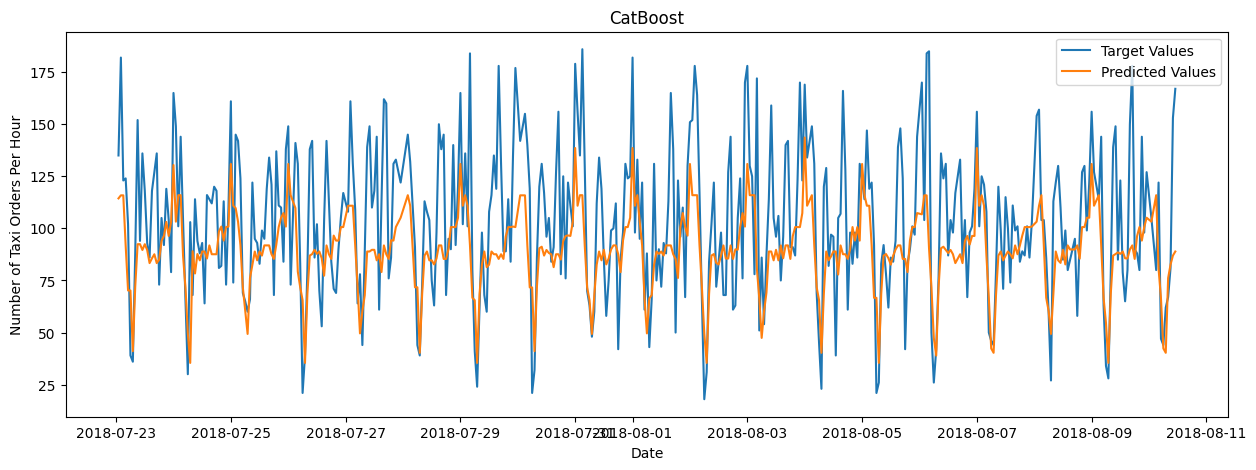


Training time for CatBoost : 4.51
Prediction time for CatBoost : 1.25
CPU times: user 1.97 s, sys: 73.9 ms, total: 2.05 s
Wall time: 4.76 s


In [16]:
%%time

# Set variables to CatBoostRegressor
model = CatBoostRegressor(random_state=12345)
model_name = 'CatBoost'

# Configure model_evaluation to use CatBoostRegressor
model_evaluation(model, model_name)

#### XGBoost

**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

Best hyperparameters For XGBoost : {'max_depth': 5, 'n_estimators': 20}
These hyperparameters produced a best RMSE score of 24.1 on the training data

The RMSE using the tuned XGBoost on the validation set: 25.16



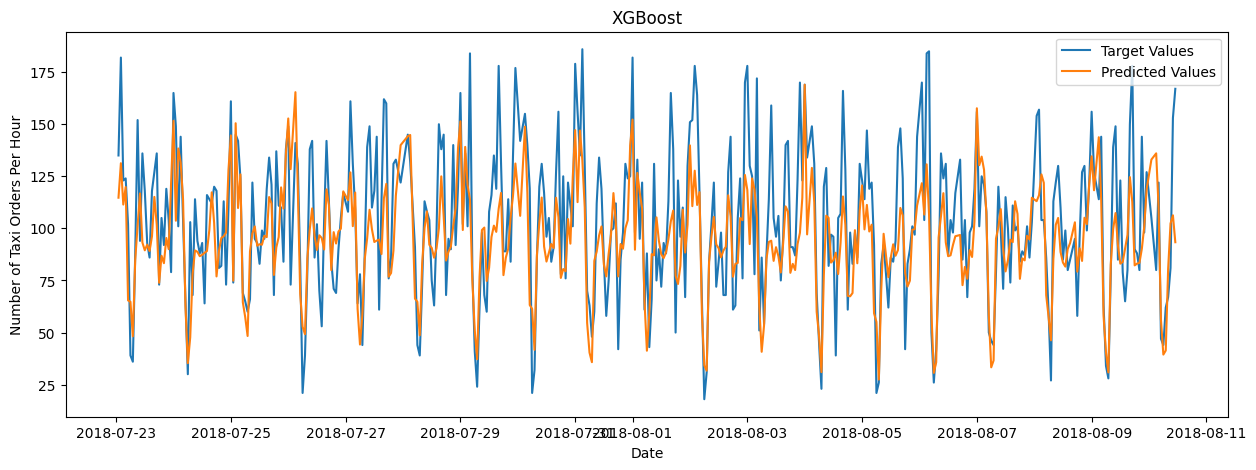


Training time for XGBoost : 79.42
Prediction time for XGBoost : 3.06
CPU times: user 1min 19s, sys: 167 ms, total: 1min 19s
Wall time: 1min 19s


In [17]:
%%time

# Set variables to XGBRegressor
model = XGBRegressor(random_state=12345)
model_name = 'XGBoost'

# Configure model_evaluation to use XGBRegressor
model_evaluation(model, model_name)

#### Auto-ARIMA

Auto-ARIMA (Automated ARIMA) is a powerful tool used for time series forecasting, which automatically selects the optimal ARIMA model by determining the best parameters (p, d, q). The ARIMA model is a widely-used statistical method for modeling time-dependent data. Auto-ARIMA automates the process of fitting ARIMA models and selecting the best parameters based on model selection criteria like AIC, BIC, or cross-validation.

In [18]:
# Verifying that there are no missing or infinite values which will cause errors with auto-ARIMA
print(target_train.isnull().sum())
print(np.isfinite(target_train.sum()))
target_train.head()

0
True


datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
Name: num_orders, dtype: int64

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1945.183, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1889.588, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1943.274, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1919.433, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1878.919, Time=1.00 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1876.117, Time=2.20 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1874.740, Time=1.00 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1902.154, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1876.315, Time=1.82 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1891.295, Time=1.10 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1888.109, Time=0.91 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1860.8

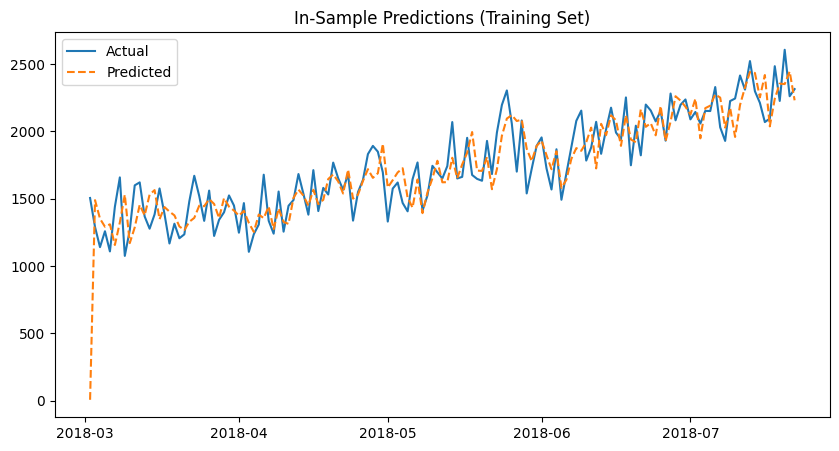

RMSE of predictions on validation data: 88.13


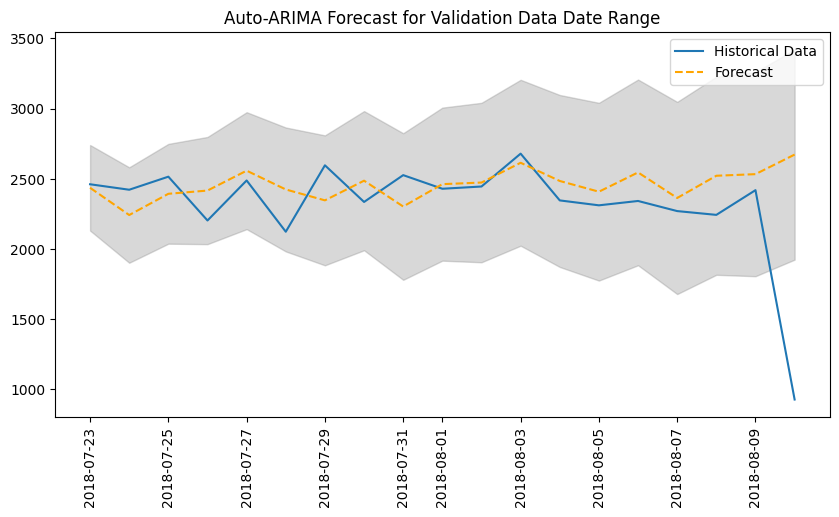

Training time elapsed: 1.98
Prediction time elapsed: 6.21


In [19]:
# This section was a bit challenging but I did my best for now
# Auto-ARIMA only requires the target variable, rather than features, so I will use target_train and target_valid
# I had to switch to daily resample because hourly was crashing the kernel even with order limits
# Giving new names because I need the datasets again for the next section
target_train_arima = target_train.resample('D').sum()
target_valid_arima = target_valid.resample('D').sum()

# Choose Auto-ARIMA model
model = auto_arima(target_train_arima,
                   seasonal=True,          # Data has seasonality
                   m=7,                    # Daily seasonality (7 days per week)
                   stepwise=True,          # True is faster and more direct
                   suppress_warnings=True, 
                   trace=True)             # Show progress
                   #max_p=2,               # I had to impose order limits due to kernel crashing but removed them when I resampled weekly
                   #max_q=2, 
                   #max_P=1, 
                   #max_Q=1)             

print(model.summary())

# Start training timer
start_train = time.time()

# Train the model on training set
model.fit(target_train_arima)

# End training timer and calculate trainingtime elapsed
end_train = time.time()
elapsed_train = end_train - start_train

# Make in-sample predictions on training set
predictions = model.predict_in_sample()

# Calculate RMSE of predictions on in-sample predictions vs training data and divide by 24 to bring in line with hourly RMSE
rmse = np.sqrt(mean_squared_error(target_train_arima, predictions)) / np.sqrt(24)
print('RMSE of predictions on training data:', round(rmse,2))

# Plot actual vs predicted values without forecasting, on training set
plt.figure(figsize=(10, 5))
plt.plot(target_train_arima.index, target_train_arima, label="Actual")
plt.plot(target_train_arima.index, predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.title("In-Sample Predictions (Training Set)")
plt.show()

# Forecast predicted values that correspond to time period of target validation set
# Generate forecast df with index matching that of target_valid_arima to store forecast
forecast_df = pd.DataFrame(index=target_valid_arima.index)

# Start prediction timer
start_pred = time.time()

# Generate forecast for dates equal to inde of target_valid_arima along with confidence interval
forecast, conf_int = model.predict(n_periods=len(forecast_df), return_conf_int=True)

# End prediction timer and calculate elapsed prediction time in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Add the forecast to the forecast DataFrame
forecast_df['forecast'] = forecast
forecast_df['lower_conf'] = conf_int[:, 0]
forecast_df['upper_conf'] = conf_int[:, 1]

# Calculate RMSE of predictions on forecast vs validation data and divide by sqrt24 to approximately bring in line with hourly RMSE
rmse = np.sqrt(mean_squared_error(target_valid_arima, forecast_df['forecast'])) / np.sqrt(24)
print('RMSE of predictions on validation data:', round(rmse,2))

# Plot the historical and forecasted data
plt.figure(figsize=(10, 5))
plt.plot(target_valid_arima.index, target_valid_arima, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_df.index, forecast_df['lower_conf'], forecast_df['upper_conf'], color='gray', alpha=0.3)
plt.title('Auto-ARIMA Forecast for Validation Data Date Range')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Print training and prediction times
print('Training time elapsed:', round(elapsed_train,2))
print('Prediction time elapsed:', round(elapsed_pred,2))

### Model Training and Tuning Results

Model comparison results are in the table below. Note: hyperparameter tuning time was not monitored (although it can be closely estimated with my inclusion of `%%time` in each code cell) - only training and prediction times.

| Model | RMSE (Training/Tuning) | RMSE (Validation) | Training Time (s) | Prediction Time (ms) | Optimal Hyperparameters
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| Linear Regression   | N/A   | 32.83   | 0.01   | 1.29  | N/A
| Random Forest   | 23.45   | 25.43  | 2.64   | 2.60  | `max_depth=10`, `n_estimators=20`
| LightGBM  | 23.80   | 27.09   | 2.88  | 2.06   | `max_depth=20`, `n_estimators=20`
| CatBoost  | 25.66   | 30.88   | 4.27  | 1.05   |`max_depth=5`, `n_estimators=5`
| XGBoost  | 24.10  | 25.16  | 9.76   | 2.94  |`max_depth=5`, `n_estimators=20`
| ARIMA  |  41.75  | 88.13   | 1.89  | 6.71   | `p=3`, `d=1`, `q=0`, `P=1`, `D=0`, `Q=1`, `m=7`

## Testing

Now that a variety of models have been trained, tuned, and compared, we will move forward with the best ones to be final candidates. They will be given the test dataset to generate predictions and the RMSE and prediction times will be compared. Note that all models tested, even Linear Regression, had RMSE below our requirement of 48, with the exception of ARIMA on the validation set.

Best models (lowest RMSE and training/prediction times):
- RandomForest - good balance of low error and speed
- XGBoost - similar to RandomForest but a bit slower

### Linear Regression
As above, Linear Regression will serve as our baseline - all models should generally outperform it.

In [20]:
%%time 

# Initialize model
model = LinearRegression()

# Fit model to training data
model.fit(features_train, target_train)

# Start prediction timer
start_pred = time.time()

# Predict test target
predicted_values = model.predict(features_test)

# End prediction timer and calculate prediction time elapsed in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

# Print RMSE
print('The RMSE for the Linear Regression model (validation set) is:', round(RMSE,2))
print()
print('Prediction time for Linear Regression model:', round(elapsed_pred,2))

The RMSE for the Linear Regression model (validation set) is: 35.18

Prediction time for Linear Regression model: 1.31
CPU times: user 7.77 ms, sys: 420 µs, total: 8.19 ms
Wall time: 5.34 ms


### Random Forest

In [21]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = RandomForestRegressor(random_state=12345, n_estimators=10, max_depth=20)

# Fit model to training data
model.fit(features_train, target_train)

# Start prediction timer
start_pred = time.time()

# Predict target values on the test set
predicted_values = model.predict(features_test)

# End prediction timer and calculate elapsed prediction time in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned RandomForestRegressor on the Test Set:", round(RMSE,2))
print()
print('Prediction time for RandomForestRegressor:', round(elapsed_pred,2))

The RMSE Using the Tuned RandomForestRegressor on the Test Set: 38.84

Prediction time for RandomForestRegressor: 2.4
CPU times: user 125 ms, sys: 32 ms, total: 157 ms
Wall time: 169 ms


### XGBoost

In [22]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = XGBRegressor(random_state=12345, n_estimators=5, max_depth=20)

# Fit model to training data
model.fit(features_train, target_train)

# Start prediction timer
start_pred = time.time()

# Predict target values on the test set
predicted_values = model.predict(features_test)

# End prediction timer and calculate elapsed prediction time in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned XGBoostRegressor on the Test Set:", round(RMSE,2))
print()
print('Prediction time for XGBoostRegressor:', round(elapsed_pred,2))

The RMSE Using the Tuned XGBoostRegressor on the Test Set: 58.67

Prediction time for XGBoostRegressor: 3.89
CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 124 ms


In [23]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = RandomForestRegressor(random_state=12345, n_estimators=10, max_depth=20)

# Fit model to training data
model.fit(features_train, target_train)

# Start prediction timer
start_pred = time.time()

# Predict target values on the test set
predicted_values = model.predict(features_test)

# End prediction timer and calculate elapsed prediction time in ms
end_pred = time.time()
elapsed_pred = (end_pred - start_pred) * 1000

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned RandomForestRegressor on the Test Set:", round(RMSE,2))
print()
print('Prediction time for RandomForestRegressor:', round(elapsed_pred,2))

The RMSE Using the Tuned RandomForestRegressor on the Test Set: 38.84

Prediction time for RandomForestRegressor: 2.66
CPU times: user 128 ms, sys: 2.3 ms, total: 130 ms
Wall time: 199 ms


### Summary of Model Testing

| Model | RMSE (Test) | Prediction Time (ms) | Optimal Hyperparameters
|:----------:|:----------:|:----------:|:----------:|
| Linear Regression | 35.18 | 1.30 | N/A
| Random Forest   | 38.84  | 2.22  | `max_depth=10`, `n_estimators=20`
| XGBoost  | 58.67   | 3.10 |  `max_depth=5`, `n_estimators=20`

## Conclusion

Based on model training, tuning, and testing from 6 months of historical data, I recommend to Sweet Lift Taxi company a **Random Forest** model (`max_depth=10`, `n_estimators=20`) to create the most accurate and fastest prediction of taxi rides in the next hour. 

XGBoost does not have a low enough RMSE to be an acceptable model (must be less than 48). I expected CatBoost or ARIMA to be the most accurate, but I did not see results suggestive of those models being superior during my analysis. Linear Regression is likely the best model because of the small dataset available - a more complex model does not seem to be required in this case.

In [24]:
# Note to reviewer: neither model outperformed Linear Regression on test set - I believe this to mean there are errors somewhere
# but I thought I'd make a note of it here.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48